## Topic Extraction

In [ ]:
# reference: 
# 1). http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
# 2). https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
# possible approach: LDA and NMF

In [2]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import re
import string
from sklearn.decomposition import LatentDirichletAllocation
import spacy
%config InlineBackend.figure_format = 'svg'

In [3]:
nlp = spacy.load('en')

#### Review

In [4]:
review = pd.read_csv('./yelp-dataset/yelp-dataset/yelp_review.csv')
print(review.shape)
print(review.columns)

(5261668, 9)
Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool'],
      dtype='object')


#### Business

In [5]:
# focus on restaurants
business = pd.read_csv('./yelp-dataset/yelp-dataset/yelp_business.csv')
print(business.shape)
print(business.columns)

(174567, 13)
Index(['business_id', 'name', 'neighborhood', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'categories'],
      dtype='object')


In [6]:
business['categories'] = business['categories'].str.lower()
business_rest = business[np.array(business['categories'].str.contains('restaurant'))]

In [7]:
bid = np.array(business_rest.business_id)
# filter review to include restaurants only
review = review[review['business_id'].isin(bid)]

In [8]:
star_count = dict(Counter(np.array(review['stars'])))
star, count = zip(*sorted(star_count.items(),key=itemgetter(0)))

Text(0.5,1,"User's rating distribution")

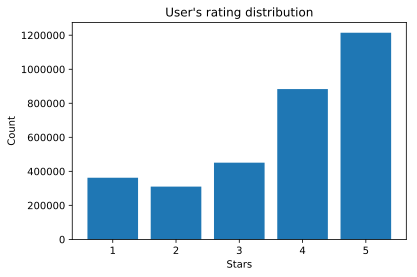

In [9]:
plt.bar(np.arange(len(star))+1,np.array(count))
plt.xlabel('Stars')
plt.ylabel('Count')
plt.title('User\'s rating distribution')

### Topic Extraction

In [12]:
def makeWordList(review):
    for c in string.punctuation:
        review = review.replace(c, "") #--- remove punctuation
    text = re.sub(r'\n','',review) #--- remove \n
    
    text = text.lower().split()
    li = []
    for token in text:
        li.append(token)
        
    return ' '.join(li) #--- return a string

In [13]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','ADV']): #'VERB'
    texts_output = []
    for sent in texts:
        doc = nlp(sent)
        texts_output.append(' '.join([token.lemma_ for token in doc if token.pos_ in allowed_postags]))
    return texts_output

#### 1). one-star review

In [11]:
# extract one star review
one_star_idx = np.where(review['stars']==1)
one_star_reivew = [t for t in review.iloc[one_star_idx]['text']]

In [12]:
one_star = [makeWordList(review) for review in one_star_reivew]

In [13]:
len(one_star)

362166

In [14]:
# for computation speed, randomly select 150,000 out of 362,166
one_star_randidx = np.random.permutation(len(one_star))[:150000]
one_star_small = [one_star[idx] for idx in one_star_randidx]

In [15]:
one_star_lemma = lemmatization(one_star_small)

In [16]:
# use raw term count for LDA (countVectorizer instead of tfidfVectorizer)
vocab_size = 1000
tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=10,
                                max_features=vocab_size,
                                stop_words='english')
X = tf_vectorizer.fit_transform(one_star_lemma)

In [17]:
components = 5
lda = LatentDirichletAllocation(n_components=components,verbose=1,max_iter=15,random_state=28584096,learning_method='online')
X_ = lda.fit_transform(X)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15


In [18]:
word = np.array(tf_vectorizer.get_feature_names())

for i in range(components):
    sort_idx = np.argsort(lda.components_[i,:])[-15:]
    print('Topic',i)
    for w in sort_idx:
        print(word[w])
    print()

Topic 0
price
people
bad
make
look
think
restaurant
try
review
really
just
food
good
place
pron

Topic 1
make
taco
fry
location
soup
just
place
say
cheese
sandwich
burger
time
pizza
pron
order

Topic 2
drink
service
just
manager
food
time
tell
table
minute
wait
ask
say
come
order
pron

Topic 3
experience
staff
restaurant
rude
poor
customer
slow
time
terrible
horrible
good
place
bad
service
food

Topic 4
meat
rice
bad
sauce
meal
dish
salad
come
eat
order
good
taste
chicken
food
pron



In [ ]:
# print(X_.shape)
# np.savetxt('LDA_starone.txt',X_)

- Topic 1: Price
- Topic 2: Location
- Topic 3: Time
- Topic 4: Service
- Topic 5: Food


#### 2). five-star review

In [14]:
# extract five stars only
five_star_idx = np.where(review['stars']==5)
five_star_reivew = [t for t in review.iloc[five_star_idx]['text']]

In [15]:
# keep only 150000 rows
five_star_randidx = np.random.permutation(len(five_star_reivew))[:150000]
five_star_small = [five_star_reivew[idx] for idx in five_star_randidx]

In [16]:
five_star_small = [makeWordList(review) for review in five_star_small]

In [17]:
five_star_lemma = lemmatization(five_star_small)

In [18]:
# use raw term count for LDA (countVectorizer instead of tfidfVectorizer)
vocab_size = 1000
tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=10,
                                max_features=vocab_size,
                                stop_words='english')
X_five = tf_vectorizer.fit_transform(five_star_lemma)
word = np.array(tf_vectorizer.get_feature_names())

In [19]:
components = 5
lda = LatentDirichletAllocation(n_components=components,verbose=1,max_iter=15,random_state=28584096,learning_method='online')
X_five = lda.fit_transform(X_five)
print(X_five.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
(150000, 5)


In [21]:
for i in range(components):
    sort_idx = np.argsort(lda.components_[i,:])[-15:]
    print('Topic',i)
    for w in sort_idx:
        print(word[w])
    print()

Topic 0
order
day
little
coffee
great
fry
food
really
sandwich
burger
just
time
place
good
pron

Topic 1
potato
salad
just
rice
flavor
sweet
meat
beef
pork
cheese
delicious
sauce
good
chicken
pron

Topic 2
sushi
restaurant
time
price
definitely
delicious
amazing
staff
friendly
pron
service
good
place
great
food

Topic 3
amazing
good
meal
great
server
table
night
dinner
menu
experience
service
time
restaurant
food
pron

Topic 4
sauce
menu
option
place
pasta
great
ingredient
italian
dish
delicious
pron
good
fresh
salad
pizza



- Topic1: Food
- Topic2: Food
- Topic3: Price
- Topic4: Service
- Topic5: Food 